In [ ]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 34.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle5 as pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
import tensorflow as tf
seed=2022
tf.random.set_seed(seed)
np.random.seed(seed)

## 기타 데이터 가공

In [ ]:
df2=pd.read_csv('/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/csv파일/train_df_최종본_15세미만_65세이상.csv')
df2

uuid  cough_detected        SNR  gender  \
0    009b1e22-f451-40ae-9cbf-9f1ff5dec022          0.9743  16.461916    male   
1    02bcadc9-b1d1-41d4-9660-2b70216cb81b          0.7553  15.571817    male   
2    040f3aa7-2afc-4ca4-925a-e7e25591fe56          0.9688  13.107982    male   
3    046487f9-ed2e-4282-9f0b-d6a98c06df48          0.3950   0.000000    male   
4    063ce221-0379-4af2-a322-ac0094c664a3          0.6798   9.435173    male   
..                                    ...             ...        ...     ...   
118  a12a101c-c947-42ff-b6b6-57852720e82e          0.0643   0.000000  female   
119  ab46097a-7d5b-47f3-aab8-222bf0043beb          1.0000  15.377455  female   
120  ce914437-433f-4dfa-a38b-cecc37f7acd2          0.1643   0.000000  female   
121  e3244803-32bb-4706-b14a-0bfb384b96de          0.0156  12.372729  female   
122  e3bc1069-6c55-448f-8d73-8d6b8aaa715a          1.0000  13.156244  female   

     man  respiratory_condition  fever_muscle_pain  COVID-19  healthy  \
0      1                      0                  0         0        1   
1      1                      0                  0         0        1   
2      1                      0                  0         0        1   
3      1                      0                  0         0        1   
4      1                      0                  0         0        1   
..   ...                    ...                ...       ...      ...   
118    0                      1                  0         1        0   
119    0                      0                  0         1        0   
120    0                      0                  0         1        0   
121    0                      1                  0         1        0   
122    0                      0                  0         1        0   

     symptomatic  15세미만  15세이상65세미만  65세이상  
0              0      1           0      0  
1              0      1           0      0  
2              0      1           0      0  
3              0      1           0      0  
4              0      1           0      0  
..           ...    ...         ...    ...  
118            0      0           0      1  
119            0      0           0      1  
120            0      0           0      1  
121            0      0           0      1  
122            0      0           0      1  

[123 rows x 13 columns]

In [ ]:
X2=[]
y2=[]
for i in range(len(df2)):
  for _ in range(18):     # 오그멘테이션 숫자만큼 range()안에 넣어줘야됨
    X2.append(list(df2.iloc[i, [4,5,6,7]].values))

In [ ]:
X2=pd.DataFrame(X2)
X2

0  1  2  3
0     1  0  0  0
1     1  0  0  0
2     1  0  0  0
3     1  0  0  0
4     1  0  0  0
...  .. .. .. ..
2209  0  0  0  1
2210  0  0  0  1
2211  0  0  0  1
2212  0  0  0  1
2213  0  0  0  1

[2214 rows x 4 columns]

## 음성 데이터 가공

In [ ]:
with open("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/mfcc/mfcc_other.pickle","rb") as fr:
    data = pickle.load(fr)

length=[]
for i in range(len(data)):
    length.append(data[i].shape[1])
    
min_len=min(length)

result=[]
for i in range(len(data)):
    result.append(data[i][:,:min_len])
    
result_data=np.array(result)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    result_data, X2, stratify = X2, test_size = 0.2
)

In [ ]:
features_train = Y_train.iloc[:,:-1].values
y_data_train = Y_train.iloc[:,-1].values
features_test = Y_test.iloc[:,:-1].values
y_data_test = Y_test.iloc[:,-1].values

In [ ]:
img_input=Input(shape=(30,901,1), name='cough_sound')
other_input=Input(shape=(3), name='other_data')

# 기침 데이터 처리 모델 구현
x_1=Conv2D(256, kernel_size=(3,3), activation='relu')(img_input)
x_1=Conv2D(256, (3,3), activation='relu')(x_1)
x_1=MaxPooling2D()(x_1)
x_1=Dropout(0.25)(x_1)
x_1=Conv2D(128, (3,3), activation='relu')(x_1)
x_1=Conv2D(128, (3,3), activation='relu')(x_1)
x_1=MaxPooling2D()(x_1)
x_1=Flatten()(x_1)
x_1=Dense(128, activation='relu')(x_1)
x_1=Dropout(0.5)(x_1)
x_1=Dense(64, activation='relu')(x_1)
x_1=Dropout(0.5)(x_1)

x_2=Dense(128, activation='relu')(other_input)
x_2=Dense(52, activation='relu')(x_2)

x=Concatenate()([x_1,x_2])

result=Dense(1, activation='sigmoid', name='test_result')(x)

model = Model([img_input,other_input], result)

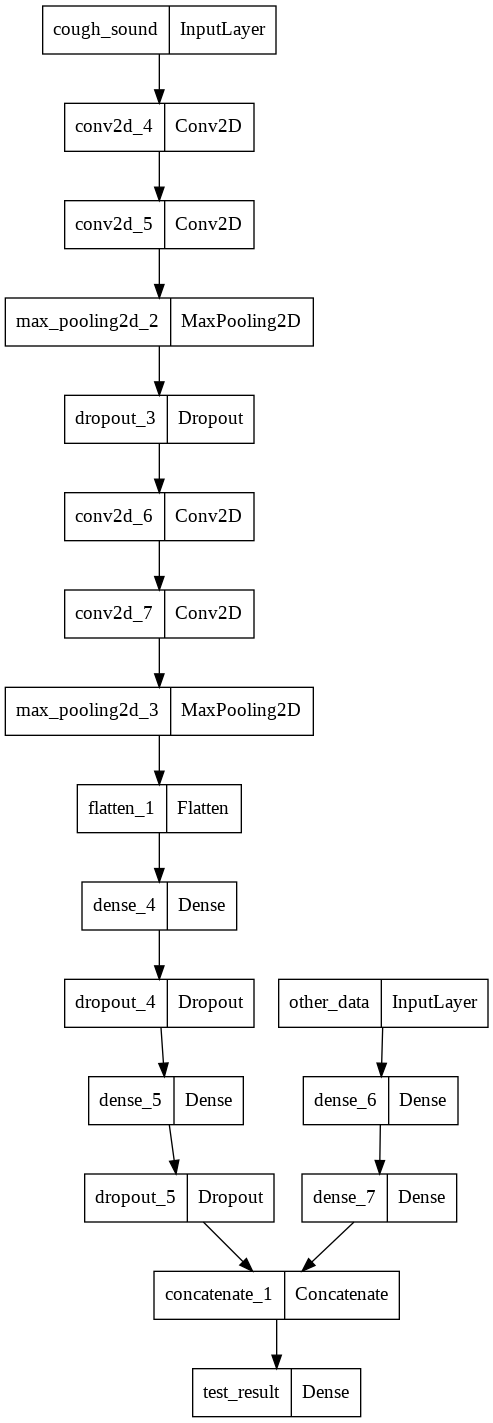

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model_path='best-covid-complex_other.h5'
mc=ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
es=EarlyStopping(patience=10)

In [ ]:
model.compile('adam', loss=['binary_crossentropy'], metrics={'test_result':'acc'})

hist=model.fit(
    [X_train, features_train], y_data_train, validation_split=0.2, epochs=50, batch_size=50, callbacks=[mc, es]
)

Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 0.6741 - acc: 0.6363
Epoch 1: val_loss improved from inf to 0.64710, saving model to best-covid-complex_other.h5
29/29 [==============================] - 94s 3s/step - loss: 0.6741 - acc: 0.6363 - val_loss: 0.6471 - val_acc: 0.6620
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.6206 - acc: 0.6977
Epoch 2: val_loss improved from 0.64710 to 0.63625, saving model to best-covid-complex_other.h5
29/29 [==============================] - 31s 1s/step - loss: 0.6206 - acc: 0.6977 - val_loss: 0.6363 - val_acc: 0.6620
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.6033 - acc: 0.6984
Epoch 3: val_loss improved from 0.63625 to 0.63542, saving model to best-covid-complex_other.h5
29/29 [==============================] - 30s 1s/step - loss: 0.6033 - acc: 0.6984 - val_loss: 0.6354 - val_acc: 0.6620
Epoch 4/50
29/29 [==============================] - ETA: 0s - loss: 0.5978 - acc: 0.6984
Epo

In [ ]:
best_model=load_model(model_path)
best_model.evaluate([X_test, features_test], [y_data_test])

14/14 [==============================] - 7s 325ms/step - loss: 0.6084 - acc: 0.6907


[0.6083781719207764, 0.690744936466217]

In [ ]:
from sklearn.metrics import confusion_matrix
y_train_pred=best_model.predict([X_test, features_test])
yhat=[]
for data in y_train_pred:
  if data>=0.5:
    yhat.append(1)
  else:
    yhat.append(0)

In [ ]:
cf = confusion_matrix(y_data_test, yhat)
print(cf)

[[177  51]
 [ 86 129]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
p = precision_score(y_data_test, yhat)
print(p)
r = recall_score(y_data_test, yhat)
print(r)
f1 = f1_score(y_data_test, yhat)
print(f1)

0.7166666666666667
0.6
0.6531645569620254
